# Pre-Processing

**Note** the image processing was done directly using the Lidar visualisation function within the radiate SDK available [here](https://githubmarcelsheeny/radiate_sdk)

## Gathering and selecting data

We started by gathering the csv data required and selecting 4000 files at random with a balanced label distribution.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import time

In [ ]:
%%time
data = []
y = []
data_path = os.getcwd()[:-15] + 'assets\dataset_csv' # dataset not included due to size restriction
for filename in os.listdir(data_path):
    f = os.path.join(data_path, filename) # find all folders
    for velofile in os.listdir(f):
        files = os.path.join(f,velofile) # find the LiDAR file in each folder
        for csvname in os.listdir(files):
            a = np.genfromtxt(os.path.join(files,csvname), delimiter=',') # retrieve CSV data
            data.append(a)
            y.append(filename) # keep label name for possible classification purposes
data = np.array(data)

In [3]:
y = np.array(y)

In [ ]:
city = y[y == 'city']
junction = y[y == 'junction']
fog = y[y == 'fog']
night = y[y == 'night']
rain = y[y == 'rain']
motorway = y[y == 'motorway']
snow = y[y == 'snow']
rural = y[y == 'rural']

# retrieve index of chosen instances
city_indeces = np.random.choice(city.shape[0],size=500,replace=False)
fog_indeces = np.random.choice(fog.shape[0],size=500,replace=False) + city.shape[0]
junction_indeces = np.random.choice(junction.shape[0],size=500,replace=False)+ city.shape[0]+ fog.shape[0]
motorway_indeces = np.random.choice(motorway.shape[0],size=500,replace=False)+ city.shape[0]+ junction.shape[0]+ fog.shape[0]
night_indeces = np.random.choice(night.shape[0],size=500,replace=False)+ city.shape[0]+ junction.shape[0]+ fog.shape[0]+ motorway.shape[0]
rain_indeces = np.random.choice(rain.shape[0],size=500,replace=False)+ city.shape[0]+ junction.shape[0]+ fog.shape[0]+ motorway.shape[0]+ night.shape[0]
rural_indeces = np.random.choice(rural.shape[0],size=500,replace=False)+ city.shape[0]+ junction.shape[0]+ fog.shape[0]+ motorway.shape[0]+ night.shape[0]+ rain.shape[0]
snow_indeces = np.random.choice(snow.shape[0],size=500,replace=False)+ city.shape[0]+ junction.shape[0]+ fog.shape[0]+ motorway.shape[0]+ night.shape[0]+ rain.shape[0]+ rural.shape[0]
indeces = np.concatenate((city_indeces,fog_indeces,junction_indeces,motorway_indeces,night_indeces,rain_indeces,rural_indeces,snow_indeces))

In [ ]:
reduced_dataset = data[indeces]
reduced_y = np.array([['city']*500,['fog']*500,['junction']*500,['motorway']*500,['night']*500,['rain']*500,['rural']*500, ['snow']*500]).flatten()

In [ ]:
np.savez('./assets/clustered_data/4000_csv.npz', reduced_dataset,reduced_y) # Save new smaller dataset

## Clustering

Our first naive attempt at transforming this data of varying shapes into neural network digestible code was by clustering the N points of each scan into 4000 points each  using Kmeans clustering

In [ ]:
%%time
Clustered_x = []
count = 0
for x in reduced_dataset:
    st = time.time()
    # Perform clustering
    kmeans = KMeans(n_clusters=4000, random_state=0).fit(x[:,:-1])
    centroids = kmeans.cluster_centers_
    Clustered_x.append(centroids)
    et = time.time()
    # get the execution time
    elapsed_time = et - st
    print('Execution time for lidar ', count ,': ', elapsed_time, 'seconds')
    count+=1

In [ ]:
Clustered_x[0].shape # New shape of one Lidar scan

In [ ]:
np.savez('./assets/clustered_data/small_Lidar.npz', Clustered_x)

In [4]:
Clustered_x = np.load('./assets/clustered_data/small_Lidar.npz',allow_pickle=True)['arr_0']
reduced_dataset = np.load('./assets/clustered_data/4000_csv.npz',allow_pickle=True)['arr_0']

C:\Users\youss\AppData\Local\Temp\ipykernel_13828\2967742344.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


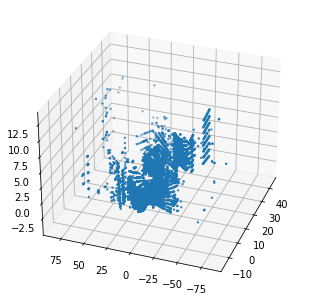

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(reduced_dataset[0][:,0], reduced_dataset[0][:,1], reduced_dataset[0][:,2], s=2)
ax.view_init(azim=200)
plt.savefig('assets/pre-cluster.png')
plt.show()

C:\Users\youss\AppData\Local\Temp\ipykernel_13828\3447939594.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


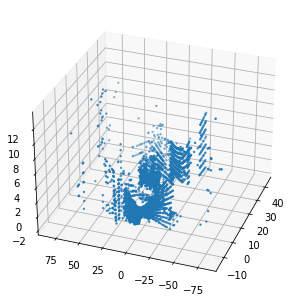

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Clustered_x[2][:,0], Clustered_x[2][:,1], Clustered_x[2][:,2], s=2)
ax.view_init(azim=200)
plt.savefig('assets/clustered.png')
plt.show()

## Gathering Polar Coordinates

First we need to get the distance, elevation and azimuth angle for each point for each scan.

In [ ]:
def calc_phi(x,y):
    return np.arctan2(y,x)
def calc_theta(x,y,z):
    return np.arccos(z/np.sqrt(x**2 + y**2 + z**2))
def calc_d(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

In [ ]:
data =np.load('./assets/clustered_data/4000_csv.npz', allow_pickle=True)['arr_0']

In [ ]:
data = np.array([np.array(data[i][:,:3]) for i in range(data.shape[0])]) # Remove reflectivity and channel from data

In [ ]:
%%time
Polar_coords = []
for scan in data:
    scan_2d = []
    # Calculate polar coords
    for point in scan:
        phi = calc_phi(point[0],point[1])
        theta = calc_theta(point[0],point[1],point[2])
        d = calc_d(point[0],point[1],point[2])
        scan_2d.append(np.array([theta,phi,d]))
        # add to list
    Polar_coords.append(np.array(scan_2d))
Polar_coords = np.array(Polar_coords)

In [ ]:
np.savez('./assets/clustered_data/az_elv_angles_distance3.npz', Polar_coords)

This image below shows all the angles where a point is visible

In [ ]:
plt.scatter(Polar_coords[0][:,0],Polar_coords[0][:,1],s=0.1)
plt.show()

With the polar coordinates we can now begin the binning process

## Final pre-processing step

**Naive binning**
Our first method for binning the data was very resource and time expensive as it used unoptimised for loops visible herebelow

In [ ]:
theta_min, theta_max = 1.3, 2.2
nb_bin_theta = 80
phi_min, phi_max = -np.pi, np.pi
nb_bin_phi = 640
theta_scale = np.linspace(theta_min, theta_max,80) # create binning range
phi_scale = np.linspace(phi_min, phi_max,640) # create binning range

In [ ]:
new_2d_scans = np.zeros((Polar_coords.shape[0],80,640,2))

In [ ]:
%%time
for k in range(Polar_coords.shape[0]):
    st = time.time()
    chosen_scan_z = data[k][:,2]
    chosen_scan = Polar_coords[k]
    current_theta = theta_scale[0]
    current_phi = phi_scale[0]
    for i in range(1,640):
        for j in range(1,80):
            # Select points in theta and phi bin range
            idx = np.where((chosen_scan[:,0] > current_theta) & (chosen_scan[:,0] < theta_scale[j]) & (chosen_scan[:,1] > current_phi) & (chosen_scan[:,1] <phi_scale[i]))
            if idx[0].size != 0:
                # Get avg z and d for the selected points
                new_z = np.average(chosen_scan_z[idx[0]])
                new_d =np.average(chosen_scan[[idx[0]],2])
                # Add points to 2d mapping based on theta and phi bins
                new_2d_scans[k][j-1][i-1] = np.array([new_d,new_z])
            else:
                new_2d_scans[k][j-1][i-1] = np.array([0,0])
            current_theta = theta_scale[j]
        current_phi = phi_scale[i]
    et = time.time()
    elapsed_time = et - st
    print('Executing Image ', k ,'/4000: ', elapsed_time, 'seconds')

On average, each image took around 9 seconds to complete meaning the total run time of this code with 4000 instances was 10 hours

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(new_2d_scans[0][:,:,0], cmap='gray')
ax.set_aspect(5)

plt.show()

In [ ]:
new_2d_scans.shape

In [ ]:
np.savez('./assets/2d_complete_data.npz', new_2d_scans)

With the polar notation of our data now calculated, we needed a way to go back to the original 3d point cloud and developed the following code

In [ ]:
scan_3d = []

current_phi = phi_scale[0]
current_theta = theta_scale[0]
for i in range(1,80):
    for j in range(1,640):
        if not np.array_equal(new_2d_scans[0][i][j], np.array([0,0])):
            # get phi and theta for current bin
            avg_phi = (current_phi+ phi_scale[j])/2
            avg_theta = (current_theta+ theta_scale[i])/2

            radius = new_2d_scans[0][i][j][0]
            # retrieve xyz coords using d, phi and theta
            x = radius * np.cos(avg_phi) * np.sin(avg_theta)
            y = radius * np.sin(avg_phi) * np.sin(avg_theta)
            z = radius * np.cos(avg_theta)
            scan_3d.append([x,y,z])
        current_phi = phi_scale[j]
    current_theta = theta_scale[i]
scan_3d = np.array(scan_3d)

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(scan_3d[:,0], scan_3d[:,1], scan_3d[:,2], s=2)
plt.show()

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[0][:,0], data[0][:,1], data[0][:,2], s=2)
plt.show()

**Efficient Binning**

Here is the efficient binning code used to gather the 3d cartesian notation in this case but which can easily be amended by changing the output.

In [ ]:
%%time

full_output = []

for m in range(Polar_coords.shape[0]):
    ts0 = time.time_ns()/10e8
    # Compute the bin to which each theta value belongs
    theta_idx = np.digitize(Polar_coords[m][:,0], theta_scale, right=False)
    # Get bin indices and  mapping to each index
    theta_bin_idx, theta_bin_inv = np.unique(theta_idx, return_inverse=True)
    ## Do the same with phi
    phi_idx = np.digitize(Polar_coords[m][:,1], phi_scale, right=False)
    phi_bin_idx, phi_bin_inv = np.unique(phi_idx, return_inverse=True)

    # get output data, attempt 2: d,z, attempt 3: d, attempt 4: xyz
    flat_data = Polar_coords[m][:,2]

    # Initialize the output
    output = np.zeros((nb_bin_theta, nb_bin_phi, 1), dtype=float) # (bin_theta, bin_phi, output data)

    # Iterate over the bins that contain at least one value
    for i, i_theta in enumerate(theta_bin_idx):
        for j, j_phi in enumerate(phi_bin_idx):
            # get the (flattened) data indices such that both theta and phi
            # belong to the corresponding theta and phi bins
            bin_idx, = np.nonzero(np.logical_and(
                theta_bin_inv == i, phi_bin_inv == j))
            if bin_idx.size > 0: # if the retrieved array of data indices is not empty
                # compute the average
                output[i_theta, j_phi] = np.average(
                    flat_data[bin_idx], axis=0)
                # if bin_idx were to be empty, taking the average would return a nan!
    full_output.append(output)
    ts1 = time.time_ns()/10e8
    print('Executing Image ', m ,'/4000: ', ts1-ts0, 'seconds')